# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster from the Freie Universität Berlin.

### Early stopping

Simulations can be run using the following command:
```
(maxsmi) $ python maxsmi/full_workflow_earlystopping.py --task lipophilicity --string-encoding smiles --aug-strategy-train augmentation_without_duplication --aug-strategy-test augmentation_without_duplication --aug-nb-train 5 --aug-nb-test 5 --ml-model CONV1D --eval-strategy True
```


### Goal

The aim of this notebook is to compare the results for a subset of models that were trained with and without early stopping.

Models that were trained are:

- ESOL: (CONV2D, Augmentation with duplication, 4),
- FreeSolv: (RNN, Augmentation with reduced duplication, 3),
- Lipophilicity: (CONV1D, Augmentation without duplication, 5).

In [1]:
import os
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Path to this notebook
HERE = Path(_dh[-1])

path_to_output = HERE.parents[0]

In [2]:
def test_RMSE(path,
              task,
              augmentation_strategy_train,
              train_augmentation,
              augmentation_strategy_test,
              test_augmentation,
              ml_model,
              string_encoding="smiles",
              trial=1):
    """
    Loads the result data from simulations with and without early stopping.

    Parameters
    ----------
    path : str
        The path to output folder.
    task : str
        The data with associated task, e.g. "ESOL", "FreeSolv"
    augmentation_strategy_train : str
        The augmentation strategy used on the train set.
    train_augmentation : int
        The number of augmentation on the train set.
    augmentation_strategy_test : str
        The augmentation strategy used on the test set.
    test_augmentation : int
        The number of augmentation on the test set.
    ml_model : str
        The machine learning model, e.g. "CONV1D".
    string_encoding : str
        The molecular encoding, default is "smiles".
    trial : int, default 1
        Iteration of the training process.

    Returns
    -------
    tuple: (float, float)
        The test RMSE without and with early stopping.
    """

    try:
        with open(
                f"{path}/output_early_stopping/output_{trial}/"
                f"{task}_{string_encoding}_{augmentation_strategy_train}_"
                f"{train_augmentation}_{augmentation_strategy_test}_"
                f"{test_augmentation}_{ml_model}_earlystopping/"
                f"results_metrics.pkl",
                "rb",
        ) as f:
            data = pickle.load(f)
            test_rmse_earlystopping = data.test[0][1]
    except FileNotFoundError:
        test_rmse_earlystopping = np.nan

    try:
        with open(
                f"{path}/output_early_stopping/output_{trial}/"
                f"{task}_{string_encoding}_{augmentation_strategy_train}_"
                f"{train_augmentation}_{augmentation_strategy_test}_"
                f"{test_augmentation}_{ml_model}/"
                f"results_metrics.pkl",
                "rb",
        ) as f:
            data = pickle.load(f)
            test_rmse_no_earlystopping = data.test[0][1]
    except FileNotFoundError:
        test_rmse_no_earlystopping = np.nan

    return (test_rmse_no_earlystopping, test_rmse_earlystopping)

FreeSolv
Test RMSE without and with early stopping on 10 runs:
 [(1.8392073512321943, 1.8566417814555312), (1.8037040487036347, 1.8615302358806867), (2.076443573580853, 1.8329236462556449), (2.433022338323056, 1.8640063255457333), (1.7808560189909532, 1.9245162284889306), (2.2297661252873935, 1.8860288029500352), (2.028570919832693, 1.888703396595393), (2.354452138091834, 1.8660613626181033), (1.8103277033573009, 1.834616733271631), (1.7754037820576978, 1.9432375078702857)] 

Mean with early stopping:			1.876
Standard deviation with early stopping:		0.034
Mean without early stopping:			2.013
Standard deviation without early stopping:	0.239


ESOL
Test RMSE without and with early stopping on 10 runs:
 [(0.760020138598659, 0.815020626983318), (0.7724580947890414, 0.8411758092026004), (0.7735152822612062, 0.8139349395148021), (0.745682057162769, 0.8012624640827969), (0.752355417143527, 0.8408880853570104), (0.7419574679196937, 0.8484782858078008), (0.7240999475673043, 0.8203273828726777),

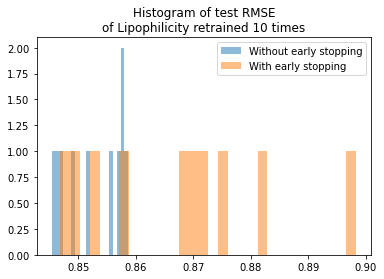

In [3]:
for TASK in ["FreeSolv", "ESOL", "Lipophilicity"]:

    if TASK == "FreeSolv":
        ML_MODEL = "RNN"
        AUGMENTATION_STRATEGY = "augmentation_with_reduced_duplication"
        AUGMENTATION_NUMBER = 3
    if TASK == "ESOL":
        ML_MODEL = "CONV2D"
        AUGMENTATION_STRATEGY = "augmentation_with_duplication"
        AUGMENTATION_NUMBER = 4
    if TASK == "Lipophilicity":
        ML_MODEL = "CONV1D"
        AUGMENTATION_STRATEGY = "augmentation_without_duplication"
        AUGMENTATION_NUMBER = 5

    print(TASK)
    list_train_iterations = [test_RMSE(path_to_output,
                                       TASK,
                                       AUGMENTATION_STRATEGY,
                                       AUGMENTATION_NUMBER,
                                       AUGMENTATION_STRATEGY,
                                       AUGMENTATION_NUMBER,
                                       ML_MODEL,
                                       trial=i) for i in range(1, 11)]
    print("Test RMSE without and with early stopping on 10 runs:\n", list_train_iterations, "\n")

    mean_with_early = np.mean([with_early[1] for with_early in list_train_iterations])
    print(f"Mean with early stopping:\t\t\t{mean_with_early:.3f}")

    std_with_early = np.std([with_early[1] for with_early in list_train_iterations])
    print(f"Standard deviation with early stopping:\t\t{std_with_early:.3f}")

    mean_without_early = np.mean([without_early[0] for without_early in list_train_iterations])
    print(f"Mean without early stopping:\t\t\t{mean_without_early:.3f}")

    std_without_early = np.std([without_early[0] for without_early in list_train_iterations])
    print(f"Standard deviation without early stopping:\t{std_without_early:.3f}\n\n")

    if TASK in ["Lipophilicity"]:
        plt.hist([without_early[0] for without_early in list_train_iterations], alpha=0.5, bins=20)
        plt.hist([with_early[1] for with_early in list_train_iterations], alpha=0.5, bins=30)
        plt.legend(["Without early stopping", "With early stopping", "mean"])
        plt.title(f"Histogram of test RMSE\nof {TASK} retrained 10 times")
        plt.show()